## Predictive modeling - Logistic Regression model (Rain tomorrow)

In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, log_loss,
    brier_score_loss, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
np.random.seed(42)


In [28]:
PATH = "../data/processed/kandy_weather_cleaned.csv"

df = pd.read_csv(PATH)

print(df.shape)
df.head()


(4916, 16)


,time,weathercode,max_temperature,min_temperature,mean_temperature,apparent_temperature_mean,shortwave_radiation,rainfall,max_wind_speed,max_wind_gust,dominant_Wind_Direction,evapotranspiration,rain_tomorrow,year,month,day
0,2010-01-01,2,25.3,18.7,22.0,23.8,18.09,0.0,15.3,38.9,57,3.43,0,2010,1,1
1,2010-01-02,2,25.6,19.4,22.2,24.8,15.47,0.0,13.3,33.1,46,2.95,1,2010,1,2
2,2010-01-03,51,25.0,19.5,22.1,25.0,14.99,0.1,10.7,28.1,40,2.84,1,2010,1,3
3,2010-01-04,51,25.3,19.0,21.9,24.3,16.55,0.6,10.4,29.2,23,3.16,0,2010,1,4
4,2010-01-05,1,25.0,16.3,20.8,22.6,22.68,0.0,9.7,27.0,28,4.18,0,2010,1,5


### Basic cleaning & assertions

- Parse dates

- Ensure target is clean (binary 0/1)

- Remove rows missing critical fields

In [29]:
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# Seasonality via MONTH as categorical
df["month"] = df["time"].dt.month.astype("Int64").astype("category")

# Ensure target exists and is binary int (0/1)
assert "rain_tomorrow" in df.columns, "Missing target column: rain_tomorrow"
if df["rain_tomorrow"].dtype not in [np.int64, np.int32, "int64", "int32"]:
    map_bin = {"Yes":1,"No":0,"Y":1,"N":0, True:1, False:0, 1:1, 0:0}
    df["rain_tomorrow"] = df["rain_tomorrow"].map(map_bin).astype("Int64").astype(int)

# If 'rain_today' exists, coerce to numeric (not mandatory if absent)
if "rain_today" in df.columns:
    df["rain_today"] = pd.to_numeric(df["rain_today"], errors="coerce")

# Drop rows without time or target (rare but safest)
df = df.dropna(subset=["time", "rain_tomorrow"]).reset_index(drop=True)

print("Rows, Cols:", df.shape)
print("Target balance (0=no rain, 1=rain):")
print(df["rain_tomorrow"].value_counts(normalize=True).round(3))


Rows, Cols: (4916, 16)
Target balance (0=no rain, 1=rain):
rain_tomorrow
1    0.8
0    0.2
Name: proportion, dtype: float64


### Engineer wind direction (circular) features

- Convert degrees → radians → sin/cos

- Drop the raw direction column to avoid redundancy

In [30]:
# Circular encoding for wind direction (if present)
if "dominant_Wind_Direction" in df.columns:
    # Coerce and wrap to [0, 360)
    df["dominant_Wind_Direction"] = pd.to_numeric(df["dominant_Wind_Direction"], errors="coerce") % 360
    rad = np.deg2rad(df["dominant_Wind_Direction"])
    df["wind_dir_sin"] = np.sin(rad)
    df["wind_dir_cos"] = np.cos(rad)
    df = df.drop(columns=["dominant_Wind_Direction"], errors="ignore")


### Chronological ordering

In [31]:
# Sort chronologically (very important for a 'tomorrow' target)
df = df.sort_values("time").reset_index(drop=True)

print("Date range:", df["time"].min(), "→", df["time"].max())


Date range: 2010-01-01 00:00:00 → 2023-06-17 00:00:00


In [32]:
# Quick nulls & schema check
print("Top columns by missing values:")
print(df.isna().sum().sort_values(ascending=False).head(12))

# Glance at key columns if you like
key_cols = [c for c in ["weathercode","rainfall","max_wind_speed","max_wind_gust",
                        "evapotranspiration","rain_today","mean_temperature",
                        "wind_dir_sin","wind_dir_cos"] if c in df.columns]
df[key_cols].head(3)


Top columns by missing values:
time                         0
weathercode                  0
max_temperature              0
min_temperature              0
mean_temperature             0
apparent_temperature_mean    0
shortwave_radiation          0
rainfall                     0
max_wind_speed               0
max_wind_gust                0
evapotranspiration           0
rain_tomorrow                0
dtype: int64


,weathercode,rainfall,max_wind_speed,max_wind_gust,evapotranspiration,mean_temperature,wind_dir_sin,wind_dir_cos
0,2,0.0,15.3,38.9,3.43,22.0,0.838671,0.544639
1,2,0.0,13.3,33.1,2.95,22.2,0.719340,0.694658
2,51,0.1,10.7,28.1,2.84,22.1,0.642788,0.766044


### Build feature lists dynamically

In [33]:
# Feature lists (month categorical)

target_col = "rain_tomorrow"
exclude = {"time", target_col}

# Numeric predictors (no year/day; no DOY sin/cos)
maybe_numeric = {
    "max_temperature","min_temperature","mean_temperature","apparent_temperature_mean",
    "shortwave_radiation","rainfall","max_wind_speed","max_wind_gust",
    "evapotranspiration","rain_today","wind_dir_sin","wind_dir_cos"
}
numeric_features = sorted(list((maybe_numeric & set(df.columns)) - exclude))

# Categorical predictors: month (+ weathercode if present)
categorical_features = ["month"]
if "weathercode" in df.columns:
    df["weathercode"] = df["weathercode"].astype("Int64").astype("category")
    categorical_features.append("weathercode")

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['apparent_temperature_mean', 'evapotranspiration', 'max_temperature', 'max_wind_gust', 'max_wind_speed', 'mean_temperature', 'min_temperature', 'rainfall', 'shortwave_radiation', 'wind_dir_cos', 'wind_dir_sin']
Categorical features: ['month', 'weathercode']


### Chronological train/test/validate split

In [34]:
# Time-based split with validation (70/10/20)

n = len(df)
test_frac = 0.20
val_frac  = 0.10  
train_end = int(n * (1 - test_frac - val_frac))
val_end   = int(n * (1 - test_frac))           

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

feature_cols = numeric_features + categorical_features

X_train = train_df[feature_cols]
y_train = train_df[target_col].astype(int)

X_val   = val_df[feature_cols]
y_val   = val_df[target_col].astype(int)

X_test  = test_df[feature_cols]
y_test  = test_df[target_col].astype(int)

print("Sizes:")
print("  Train:", X_train.shape, "Pos rate:", y_train.mean().round(3))
print("  Val  :", X_val.shape,   "Pos rate:", y_val.mean().round(3))
print("  Test :", X_test.shape,  "Pos rate:", y_test.mean().round(3))


Sizes:
  Train: (3441, 13) Pos rate: 0.789
  Val  : (491, 13) Pos rate: 0.786
  Test : (984, 13) Pos rate: 0.849


### Preprocessing (impute + scale + encode)

In [35]:
# Preprocess: impute/scale numeric, impute/one-hot categorical

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ],
    remainder="drop"
)

print("Preprocessing ready.")


Preprocessing ready.


### Train on TRAIN, tune threshold on VAL, evaluate on TEST

In [36]:
# Train on TRAIN, pick threshold on VAL, report on TEST
logreg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs"
)

clf = Pipeline(steps=[
    ("prep", preprocess),  
    ("model", logreg)
])

# Fit on TRAIN only
clf.fit(X_train, y_train)

# --- Validate ---
proba_val = clf.predict_proba(X_val)[:, 1]
roc_val = roc_auc_score(y_val, proba_val)
pr_val  = average_precision_score(y_val, proba_val)
print(f"VAL ROC-AUC: {roc_val:.3f} | VAL PR-AUC: {pr_val:.3f}")

# Tune threshold on VAL for best F1 (you can optimize recall instead if needed)
ths = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_val, (proba_val >= t).astype(int)) for t in ths]
best_t = float(ths[int(np.argmax(f1s))])
print(f"Best VAL threshold: {best_t:.2f} (F1={max(f1s):.3f})")

# --- Final test evaluation with tuned threshold ---
proba_test = clf.predict_proba(X_test)[:, 1]
roc_test = roc_auc_score(y_test, proba_test)
pr_test  = average_precision_score(y_test, proba_test)
pred_test = (proba_test >= best_t).astype(int)

print(f"\nTEST ROC-AUC: {roc_test:.3f} | TEST PR-AUC: {pr_test:.3f}")
print("Confusion matrix [TN FP; FN TP]:")
print(confusion_matrix(y_test, pred_test))
print("\nClassification report (tuned threshold):")
print(classification_report(y_test, pred_test, digits=3))


VAL ROC-AUC: 0.897 | VAL PR-AUC: 0.967
Best VAL threshold: 0.30 (F1=0.915)

TEST ROC-AUC: 0.880 | TEST PR-AUC: 0.973
Confusion matrix [TN FP; FN TP]:
[[105  44]
 [108 727]]

Classification report (tuned threshold):
              precision    recall  f1-score   support

           0      0.493     0.705     0.580       149
           1      0.943     0.871     0.905       835

    accuracy                          0.846       984
   macro avg      0.718     0.788     0.743       984
weighted avg      0.875     0.846     0.856       984



### Model Evaluation


Training Set Performance @ threshold=0.5
   Accuracy: 0.8207
  Precision: 0.9400
     Recall: 0.8254
         F1: 0.8789
    ROC_AUC: 0.8941
     PR_AUC: 0.9670
    LogLoss: 0.4126
      Brier: 0.1305

Classification report:
              precision    recall  f1-score   support

           0      0.552     0.803     0.654       727
           1      0.940     0.825     0.879      2714

    accuracy                          0.821      3441
   macro avg      0.746     0.814     0.767      3441
weighted avg      0.858     0.821     0.831      3441


Validation Set Performance @ threshold=0.5
   Accuracy: 0.8350
  Precision: 0.9248
     Recall: 0.8601
         F1: 0.8913
    ROC_AUC: 0.8975
     PR_AUC: 0.9672
    LogLoss: 0.3804
      Brier: 0.1177

Classification report:
              precision    recall  f1-score   support

           0      0.591     0.743     0.658       105
           1      0.925     0.860     0.891       386

    accuracy                          0.835       491
 

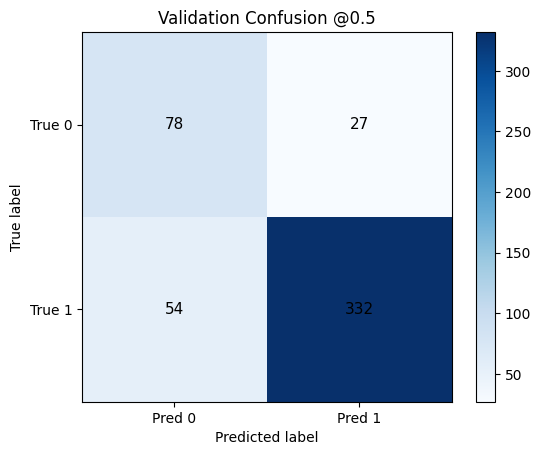

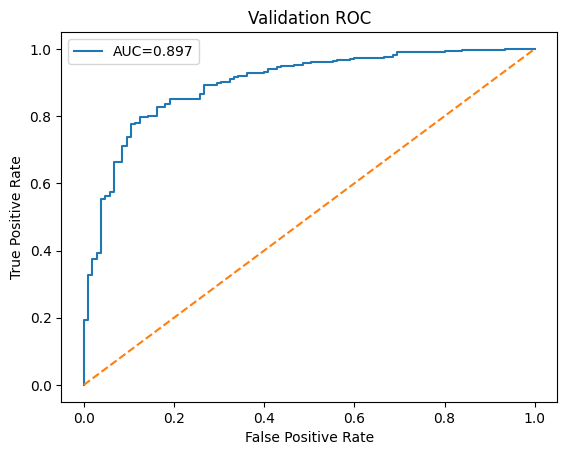

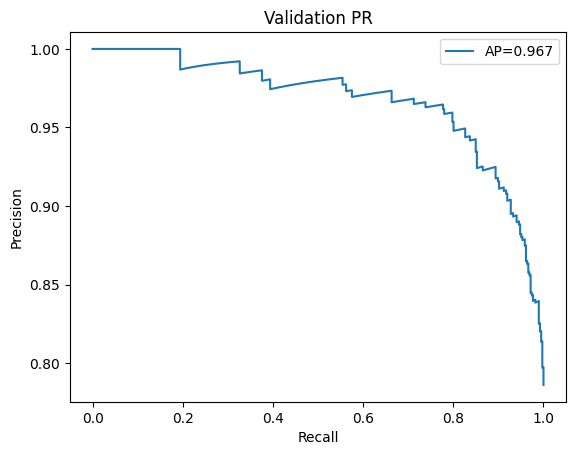

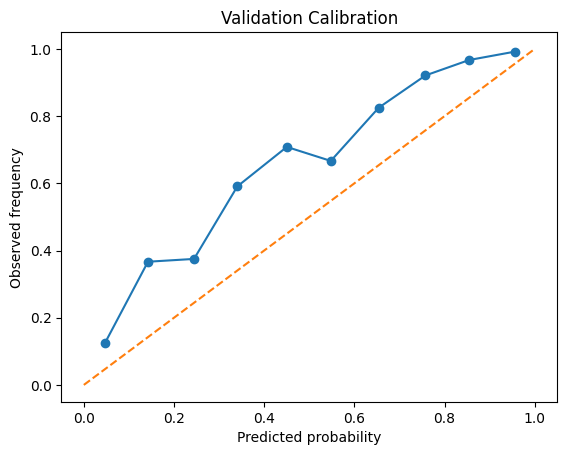


Best VAL threshold: 0.30 (F1=0.915)

TEST ROC-AUC: 0.880 | TEST PR-AUC: 0.973
Confusion matrix [TN FP; FN TP]:
[[105  44]
 [108 727]]

Classification report (tuned threshold):
              precision    recall  f1-score   support

           0      0.493     0.705     0.580       149
           1      0.943     0.871     0.905       835

    accuracy                          0.846       984
   macro avg      0.718     0.788     0.743       984
weighted avg      0.875     0.846     0.856       984



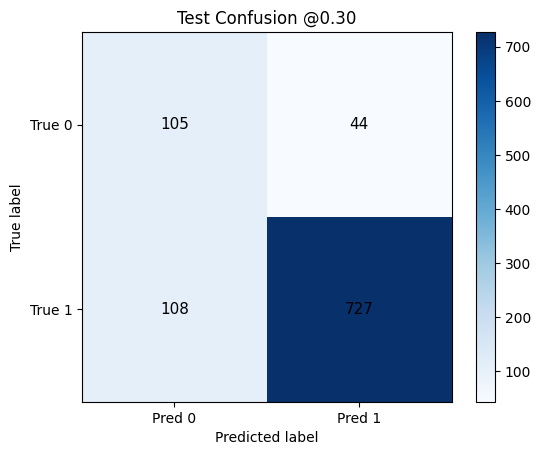

In [37]:

# --- 1. Helper: get predictions and probabilities ---
def get_scores(model, X):
    """Return predicted labels, probabilities, and decision scores if available."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        proba = model.predict(X)
    preds = (proba >= 0.5).astype(int)
    return preds, proba

# --- 2. Evaluation function ---
def evaluate_classifier(model, X, y, dataset_name=""):
    preds, proba = get_scores(model, X)
    metrics = {
        "Accuracy": accuracy_score(y, preds),
        "Precision": precision_score(y, preds, zero_division=0),
        "Recall": recall_score(y, preds, zero_division=0),
        "F1": f1_score(y, preds, zero_division=0),
        "ROC_AUC": roc_auc_score(y, proba),
        "PR_AUC": average_precision_score(y, proba),
        "LogLoss": log_loss(y, np.c_[1-proba, proba]),
        "Brier": brier_score_loss(y, proba),
    }
    print(f"\n{dataset_name} Set Performance @ threshold=0.5")
    for k,v in metrics.items():
        print(f"  {k:>9}: {v:.4f}")
    print("\nClassification report:")
    print(classification_report(y, preds, digits=3, zero_division=0))
    return {"preds": preds, "proba": proba, "metrics": metrics}

# --- 3. Plots ---
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=[0,1], yticks=[0,1],
           xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"],
           ylabel="True label", xlabel="Predicted label", title=title)
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha="center", va="center", fontsize=11)
    plt.show()

def plot_roc(y_true, proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, proba)
    auc = roc_auc_score(y_true, proba)
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], ls="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_pr(y_true, proba, title="PR Curve"):
    precisions, recalls, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.plot(recalls, precisions, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_calibration(y_true, proba, n_bins=10, title="Calibration Curve"):
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=n_bins, strategy="uniform")
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], ls="--")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title(title)
    plt.show()

# ============================
#  Baseline Evaluation @ 0.5
# ============================
train_res = evaluate_classifier(clf, X_train, y_train, "Training")
val_res   = evaluate_classifier(clf, X_val,   y_val,   "Validation")
test_res  = evaluate_classifier(clf, X_test,  y_test,  "Test")

# Example plots (Validation set)
plot_confusion(y_val, val_res["preds"], "Validation Confusion @0.5")
plot_roc(y_val, val_res["proba"], "Validation ROC")
plot_pr(y_val, val_res["proba"], "Validation PR")
plot_calibration(y_val, val_res["proba"], title="Validation Calibration")

# ============================
# Threshold tuning on VAL
# ============================
ths = np.linspace(0.05, 0.95, 19)
f1s = [f1_score(y_val, (val_res["proba"] >= t).astype(int)) for t in ths]
best_t = float(ths[int(np.argmax(f1s))])
print(f"\nBest VAL threshold: {best_t:.2f} (F1={max(f1s):.3f})")

# ============================
# Final Test Evaluation @ tuned threshold
# ============================
pred_test = (test_res["proba"] >= best_t).astype(int)
roc_test = roc_auc_score(y_test, test_res["proba"])
pr_test  = average_precision_score(y_test, test_res["proba"])

print(f"\nTEST ROC-AUC: {roc_test:.3f} | TEST PR-AUC: {pr_test:.3f}")
print("Confusion matrix [TN FP; FN TP]:")
print(confusion_matrix(y_test, pred_test))
print("\nClassification report (tuned threshold):")
print(classification_report(y_test, pred_test, digits=3, zero_division=0))
plot_confusion(y_test, pred_test, f"Test Confusion @{best_t:.2f}")


In [38]:
# ============================
# Metrics Summary Table
# ============================

def collect_metrics(res_dict, dataset_name):
    """Extract metrics from evaluation results for summary table."""
    m = res_dict["metrics"]
    return {
        "Dataset": dataset_name,
        "Accuracy": m["Accuracy"],
        "Precision": m["Precision"],
        "Recall": m["Recall"],
        "F1": m["F1"],
        "ROC_AUC": m["ROC_AUC"],
        "PR_AUC": m["PR_AUC"],
        "LogLoss": m["LogLoss"],
        "Brier": m["Brier"]
    }

# Collect metrics for baseline (0.5 threshold)
summary = []
summary.append(collect_metrics(train_res, "Train"))
summary.append(collect_metrics(val_res,   "Validation"))
summary.append(collect_metrics(test_res,  "Test"))

# Convert to DataFrame for pretty display
df_summary = pd.DataFrame(summary)
df_summary.set_index("Dataset", inplace=True)
df_summary.round(4)


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC,LogLoss,Brier
Dataset,,,,,,,,
Train,0.8207,0.9400,0.8254,0.8789,0.8941,0.9670,0.4126,0.1305
Validation,0.8350,0.9248,0.8601,0.8913,0.8975,0.9672,0.3804,0.1177
Test,0.7683,0.9634,0.7557,0.8470,0.8798,0.9733,0.4940,0.1590


In [39]:
# Add tuned Test metrics
test_metrics_tuned = {
    "Dataset": "Test (tuned)",
    "Accuracy": accuracy_score(y_test, pred_test),
    "Precision": precision_score(y_test, pred_test, zero_division=0),
    "Recall": recall_score(y_test, pred_test, zero_division=0),
    "F1": f1_score(y_test, pred_test, zero_division=0),
    "ROC_AUC": roc_test,
    "PR_AUC": pr_test,
    "LogLoss": log_loss(y_test, np.c_[1-test_res["proba"], test_res["proba"]]),
    "Brier": brier_score_loss(y_test, test_res["proba"]),
}
df_summary = pd.concat([df_summary, pd.DataFrame([test_metrics_tuned]).set_index("Dataset")])
df_summary.round(4)

,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC,LogLoss,Brier
Dataset,,,,,,,,
Train,0.8207,0.9400,0.8254,0.8789,0.8941,0.9670,0.4126,0.1305
Validation,0.8350,0.9248,0.8601,0.8913,0.8975,0.9672,0.3804,0.1177
Test,0.7683,0.9634,0.7557,0.8470,0.8798,0.9733,0.4940,0.1590
Test (tuned),0.8455,0.9429,0.8707,0.9054,0.8798,0.9733,0.4940,0.1590
